# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the training data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'conv_fgbg_model'
conv_model_name = 'conv_edgeseg_model'

n_epoch = 3  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'deepcell'
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = True  # break edges into cell-background edge, cell-cell edge
n_features = 4 if separate_edge_classes else 3

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

#### Train the model fgbg model

In [7]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/3
6983/6984 [============================>.] - ETA: 0s - loss: 0.1933 - model_loss: 0.0453 - model_1_loss: 0.0407 - model_2_loss: 0.0402 - model_3_loss: 0.0387 - model_acc: 0.9478 - model_1_acc: 0.9483 - model_2_acc: 0.9490 - model_3_acc: 0.9479
Epoch 00001: val_loss improved from inf to 0.29938, saving model to /data/models/conv_fgbg_model.h5
6984/6984 [==============================] - 949s 136ms/step - loss: 0.1934 - model_loss: 0.0453 - model_1_loss: 0.0407 - model_2_loss: 0.0403 - model_3_loss: 0.0387 - model_acc: 0.9478 - model_1_acc: 0.9483 - model_2_acc: 0.9490 - model_3_acc: 0.9479 - val_loss: 0.2994 - val_model_loss: 0.0704 - val_model_1_loss: 0.0643 - val_model_2_loss: 0.0698 - val_model_3_loss: 0.0662 - val_model_acc: 0.9829 - val_model_1_acc: 0.9817 - val_mod

### Next, Create a model for the edge/interior segmentation

#### Instantiate the segmentation transform model

In [8]:
from deepcell import model_zoo

conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

#### Train the segmentation transform model

In [9]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    transform=transform,
    dilation_radius=dilation_radius,
    separate_edge_classes=separate_edge_classes,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 216, 256, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/3
6983/6984 [============================>.] - ETA: 0s - loss: 1.0645 - model_5_loss: 0.2514 - model_6_loss: 0.2522 - model_7_loss: 0.2522 - model_8_loss: 0.2510 - model_5_acc: 0.8046 - model_6_acc: 0.8035 - model_7_acc: 0.8036 - model_8_acc: 0.8042
Epoch 00001: val_loss improved from inf to 1.27325, saving model to /data/models/conv_edgeseg_model.h5
6984/6984 [==============================] - 1446s 207ms/step - loss: 1.0644 - model_5_loss: 0.2514 - model_6_loss: 0.2521 - model_7_loss: 0.2522 - model_8_loss: 0.2510 - model_5_acc: 0.8046 - model_6_acc: 0.8035 - model_7_acc: 0.8036 - model_8_acc: 0.8042 - val_loss: 1.2733 - val_model_5_loss: 0.3084 - val_model_6_loss: 0.3024 - val_model_7_loss: 0.3073 - val_model_8_loss: 0.2968 - val_model_5_acc: 0.9566 - val_model_6_acc: 

### Run the model

#### Make predictions on test data

In [10]:
test_images = conv_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1552, 216, 256, 4)
segmentation mask shape: (1552, 216, 256, 2)


#### Post-processing

In [11]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

test_images_post_fgbg = test_images * fg_thresh

In [14]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(test_images_post_fgbg.shape[0]):
    interior = test_images_post_fgbg[i, ..., 2] > .2
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)

print('labeled_images shape:', labeled_images.shape)

/usr/local/lib/python3.5/dist-packages/skimage/morphology/misc.py:127: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


labeled_images shape: (1552, 216, 256, 1)


Image number: 1198


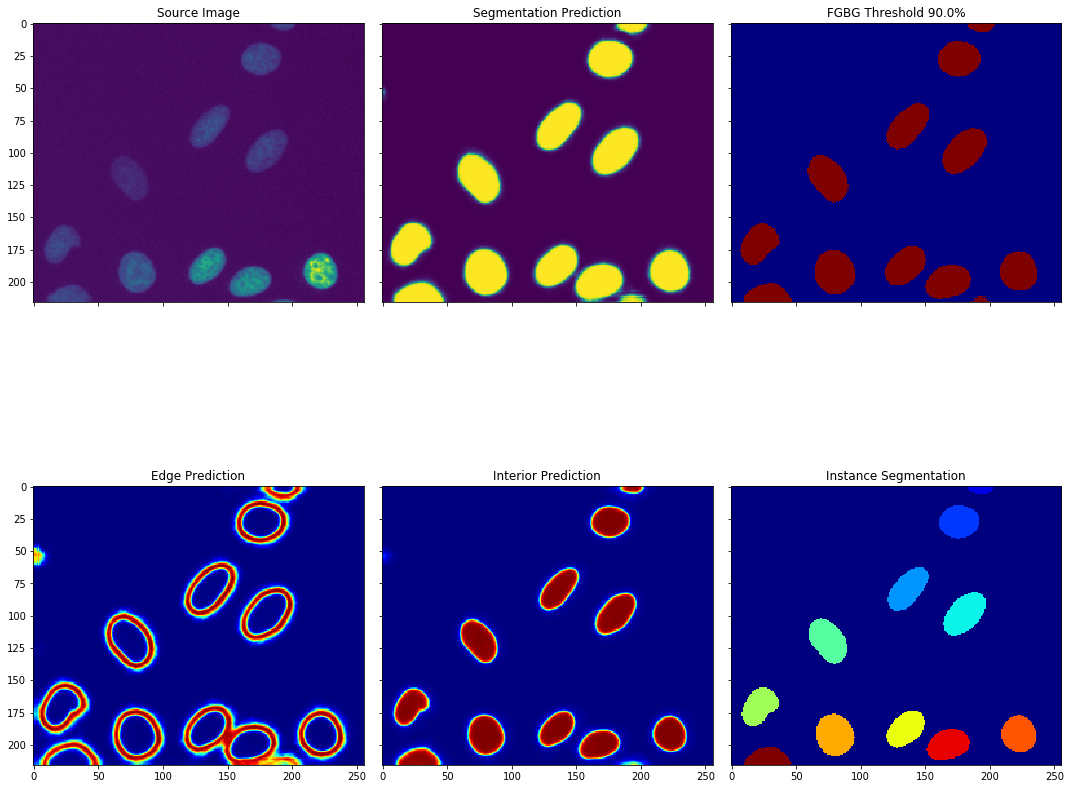

In [15]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')

fig.tight_layout()
plt.show()